In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import zipfile
import os
import json
import multiprocessing as mp
from multiprocessing import Pool, cpu_count
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from collections import Counter

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
zip_file_path = "/content/drive/MyDrive/NLP/pdf_json.zip"

In [4]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    files_list = zip_ref.namelist()
    for file in tqdm(files_list, desc="Extracting files"):
        zip_ref.extract(file,"/content/drive/MyDrive/NLP" )

Extracting files: 100%|██████████| 56530/56530 [14:17<00:00, 65.96it/s]


In [5]:
def json_extracter(file_path):
    '''Extracts text from a JSON file and returns it as a string.'''

    # Convert JSON file to dictionary
    with open(file_path, 'r') as file:
        data_dict = json.load(file)

    # Initialize the text variable
    text = data_dict.get("metadata", {}).get("title", "")

    # Extract text from 'abstract' field
    for item in data_dict.get("abstract", []):
        text += " " + item.get("text", "")

    # Extract text from 'body_text' field
    for item in data_dict.get("body_text", []):
        text += " " + item.get("text", "")

    # Extract text from 'bib_entries' field
    for value in data_dict.get("bib_entries", {}).values():
        text += " " + value.get("title", "")

    # Extract text from 'ref_entries' field
    for value in data_dict.get("ref_entries", {}).values():
        text += " " + value.get("text", "")

    return text

def process_folders(input_folder, output_json_path):
    '''Processes all JSON files in subfolders and stores their text in a single JSON file with progress tracking.'''

    # Dictionary to store the extracted text with document name as the key
    extracted_data = {}

    # Traverse all subfolders and process JSON files
    json_files = []
    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))

    # Use tqdm to show progress
    for file_path in tqdm(json_files, desc="Processing JSON files"):
        # Extract text from the JSON file
        extracted_text = json_extracter(file_path)
        # Use the file name (without extension) as the key in the dictionary
        document_name = os.path.splitext(os.path.basename(file_path))[0]
        extracted_data[document_name] = extracted_text

    # Write the dictionary to a single JSON file
    with open(output_json_path, 'w') as output_file:
        json.dump(extracted_data, output_file, indent=4)

In [6]:
input_folder = '/content/drive/MyDrive/NLP/pdf_json'
output_json_path = '/content/drive/MyDrive/NLP/text_ext.json'

process_folders(input_folder, output_json_path)

Processing JSON files: 100%|██████████| 56528/56528 [10:41<00:00, 88.18it/s]


In [2]:
def preprocess_text(text):
    '''Preprocesses the given text.'''

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove non-word and non-whitespace characters (excluding alphabets and spaces)
    text = re.sub(r'[^\w\s]', '', text)

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Remove stopwords without tokenization
    stop_words = set(stopwords.words('english'))
    filtered_text = ' '.join([word for word in text.split() if word not in stop_words])

    return filtered_text

def preprocess_document(item):
    '''Helper function to preprocess a single document's text.'''
    document_name, text = item
    return document_name, preprocess_text(text)

def preprocess_json_data(input_json_path, output_json_path):
    '''Preprocesses the text data in a JSON file using multiprocessing.'''

    # Load the JSON data
    with open(input_json_path, 'r') as input_file:
        data = json.load(input_file)

    # Prepare data for multiprocessing (convert dictionary items to a list of tuples)
    items = list(data.items())

    # Use multiprocessing to preprocess the text data
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(preprocess_document, items), total=len(items), desc="Preprocessing texts"))

    # Convert the list of tuples back into a dictionary
    processed_data = dict(results)

    # Save the processed data to a new JSON file
    with open(output_json_path, 'w') as output_file:
        json.dump(processed_data, output_file, indent=4)

In [3]:
preprocess_json_data("/content/drive/MyDrive/NLP/text_ext.json", "/content/drive/MyDrive/NLP/clean_text_ext.json")

Preprocessing texts: 100%|██████████| 56528/56528 [11:02<00:00, 85.37it/s]


In [2]:
import gc
def tokenize_and_count(chunk):
    '''Tokenizes the values in the chunk and counts token frequencies.'''
    token_counter = Counter()
    for value in chunk.values():
        tokens = word_tokenize(value)
        #token_lis = token_lis + tokens
        token_counter.update(tokens)
    # Free memory used by the chunk
    del chunk
    gc.collect()
    return token_counter, tokens

def split_dict(input_dict, num_chunks):
    '''Splits a dictionary into a specified number of chunks.'''
    keys = list(input_dict.keys())
    chunk_size = len(keys) // num_chunks + (len(keys) % num_chunks > 0)
    for i in range(0, len(keys), chunk_size):
        yield {k: input_dict[k] for k in keys[i:i + chunk_size]}

def process_large_json_for_distribution(input_json_path, num_chunks=500):
    '''Processes a large JSON file in chunks to calculate token distribution.'''
    # Load the JSON data
    with open(input_json_path, 'r') as input_file:
        data = json.load(input_file)

    token_lis = []

    # Initialize the total token counter
    total_token_distribution = Counter()

    # Process each chunk one by one
    for chunk in tqdm(split_dict(data, num_chunks), total=num_chunks, desc="Processing chunks"):
        # Process the chunk and update the total distribution
        token_counter,tokens = tokenize_and_count(chunk)
        total_token_distribution.update(token_counter)
        token_lis = token_lis + tokens
        # Explicitly delete the chunk and counter, and run garbage collection
        del token_counter
        del chunk
        gc.collect()

    # Free memory used by the original data
    del data
    gc.collect()

    return total_token_distribution, token_lis

In [3]:
token_distribution, token_lis = process_large_json_for_distribution("/content/drive/MyDrive/NLP/clean_text_ext.json")

# Display the top 10 most common tokens
print(token_distribution.most_common(10))

Processing chunks:  99%|█████████▉| 496/500 [23:55<00:11,  2.89s/it]


[('patients', 981647), ('covid', 752043), ('et', 695180), ('cells', 670672), ('al', 660083), ('virus', 656924), ('infection', 560708), ('study', 542505), ('disease', 516165), ('also', 504262)]


In [6]:
import numpy as np

all_words = list(token_distribution.items())

# Sort terms by frequency in descending order
all_words.sort(key=lambda item: item[1], reverse=True)

# Extract ranks and corresponding frequencies
ranks = np.arange(1, len(all_words) + 1)
frequencies = np.array([freq for _, freq in all_words])

# Step 2: Plotting log(rank) vs log(frequency) to observe Zipf's Law
log_ranks = np.log(ranks)
log_frequencies = np.log(frequencies)

In [7]:
import scipy.stats as stats
slope, intercept, r_value, p_value, std_err = stats.linregress(log_ranks, log_frequencies)
alpha = -slope

print(f"Estimated value of alpha (α): {alpha:.4f}")
print(f"R-squared: {r_value**2:.4f}")

Estimated value of alpha (α): 1.3502
R-squared: 0.9622


In [8]:
print(f"No. of vocabulary is: {len(all_words)}" )

total_tokens = np.sum(frequencies)
print(f"No. of tokens is: {total_tokens}")

No. of vocabulary is: 2058942
No. of tokens is: 176768666


In [13]:
import matplotlib.pyplot as plt
def plot_heaps_law(tokens, step_size=10000):
    # List to hold the number of tokens and the corresponding vocabulary size
    token_counts = []
    vocab_sizes = []

    # Set to hold the unique tokens (vocabulary)
    vocab_set = set()

    # Iterate over tokens in chunks of 'step_size'
    for i in range(0, len(tokens), step_size):
        # Add tokens from the current chunk to the vocabulary set
        vocab_set = set(tokens[:i + step_size])

        # Number of tokens so far
        token_count = i + step_size

        # Current vocabulary size
        vocab_size = len(vocab_set)

        # Store the values
        token_counts.append(token_count)
        vocab_sizes.append(vocab_size)

    # Plotting the graph
    #plt.figure(figsize=(10, 6))
    plt.plot(token_counts, vocab_sizes, marker='o', linestyle='-', color='b', label="Vocabulary Size")

    # Set the scale to logarithmic
    plt.xscale('log')
    plt.yscale('log')

    # Add labels and title
    plt.xlabel("Number of Tokens (log scale)")
    plt.ylabel("Vocabulary Size (log scale)")
    plt.title("Tokens vs Vocabulary Size (Heap's Law)")
    plt.legend()
    plt.grid(True, which="both", ls="--")

    # Show the plot
    plt.show()

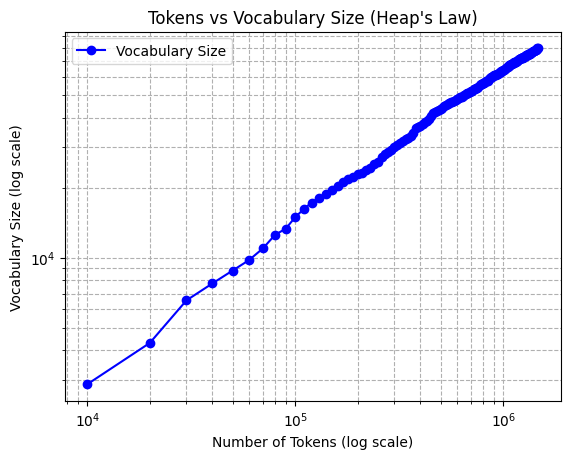

In [14]:
plot_heaps_law(token_lis)